<a href="https://colab.research.google.com/github/mesuttguven/CardiacAI/blob/main/6_ML4CS__Malware_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training IMAGE converted MALWARE Binaries with CNNs
## This Colab is from a part of the course "SGB 524 Artificial Intelligence in Cyber Security".

Mesut G. (Ph.D.) 


##Drive connection for dataset access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing necessary libraries 

In [ ]:

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Drive_IEEE/COURSES/TOBB UNI/ML4CS_TOBB/DATASETS/MALWARE_CNN_DATASET/MALWARE_IMAGE_DATASET/data_1200'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# IMAGES from the directory (from drive, cloud)
##Generates a tf.data.Dataset from image files in a directory.

In [ ]:
directory = '/content/drive/MyDrive/Drive_IEEE/COURSES/TOBB UNI/ML4CS_TOBB/DATASETS/MALWARE_CNN_DATASET/MALWARE_IMAGE_DATASET/data_120'

In [ ]:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    
)

Found 136 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#Generates a tf.data.Dataset from image files in a directory.

If your directory structure is:
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg

In [ ]:
base_dir = directory
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
train_benign_dir = os.path.join(train_dir, 'benign')  # directory with our training cat pictures
train_malicious_dir = os.path.join(train_dir, 'malicious')  # directory with our training dog pictures
validation_benign_dir = os.path.join(validation_dir, 'benign')  # directory with our validation cat pictures
validation_malicious_dir = os.path.join(validation_dir, 'malicious')  # directory with our validation dog pictures

# Understanding our data
## About this directory
This dataset was created using mallook.py (https://github.com/fieldsfieldsfields/mallook) to generate image representations of Portable Executables (PEs) of malware (malicious) and ordinary software (benign).

The 'benign' PEs were pulled from PC Magazine's The Best Free Software of 2020 (https://www.pcmag.com/picks/best-free-software). The 'malicious' PEs were pulled from the zoo (https://github.com/ytisf/theZoo).

Each folder contains only 120 DPI versions of the images using two different methods of interpolation: lanczos. 
####NOTE: Resolutions such as 300, 600, 1200 are available but for simplicity and learning purposes we only use the 120 dpi version of the images.

##Let's look at how many images we have in our training and validation directory

In [ ]:
num_benign_tr = len(os.listdir(train_benign_dir))
num_malicious_tr = len(os.listdir(train_malicious_dir))

num_benign_val = len(os.listdir(validation_benign_dir))
num_malicious_val = len(os.listdir(validation_malicious_dir))

total_train = num_benign_tr + num_malicious_tr
total_val = num_benign_val + num_malicious_val

In [ ]:
print('total training benign images:', num_benign_tr)
print('total training malicious images:', num_malicious_tr)

print('total validation benign images:', num_benign_val)
print('total validation malicious images:', num_malicious_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training benign images: 46
total training malicious images: 56
total validation benign images: 15
total validation malicious images: 19
--
Total training images: 102
Total validation images: 34


# Setting Model Parameters

For convenience, let us set up variables that will be used later while pre-processing our dataset and training our network.

In [ ]:
BATCH_SIZE = 10
IMG_SHAPE  = 120 # Our training data consists of images with width of 120 pixels and height of 120 pixels

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk and will apply rescaling and will resize them into required dimensions using single line of code.

# Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Flipping the image horizontally

We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This is achieved by passing `horizontal_flip=True` as an argument to the `ImageDataGenerator` class.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 102 images belonging to 2 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

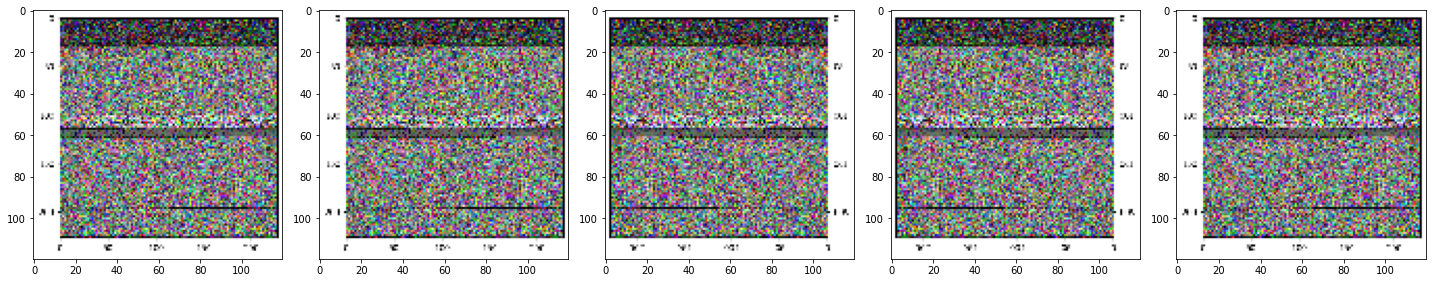

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Rotating the image

The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [ ]:
# Rotate the images 
image_gen_rotate = ImageDataGenerator(rescale=1./255, rotation_range=50)



train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 102 images belonging to 2 classes.


To see the transformation in action, let's once again take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

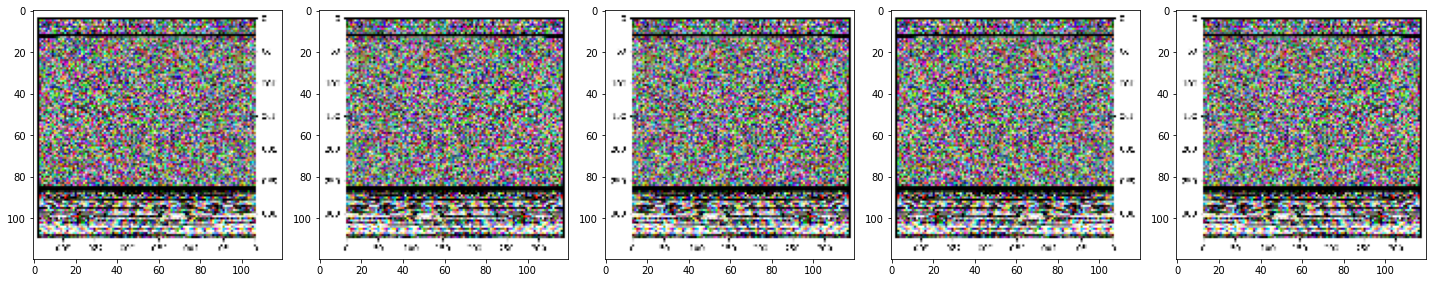

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Zoom

We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 102 images belonging to 2 classes.


One more time, take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

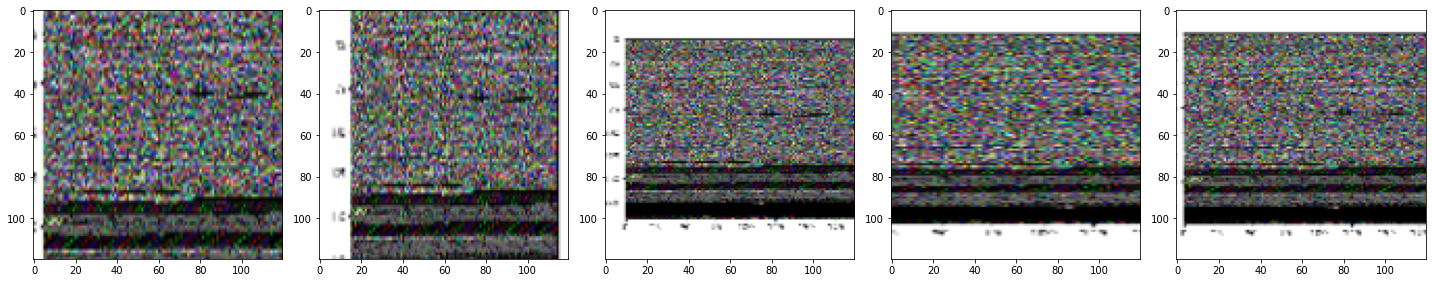

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Putting it all together

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 50 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [ ]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 102 images belonging to 2 classes.


Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset. 

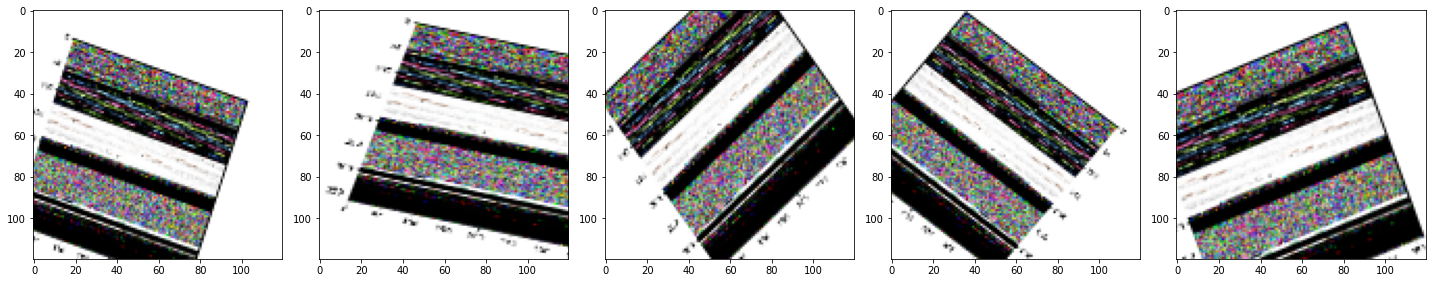

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 34 images belonging to 2 classes.


# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(120, 120, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Compiling the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 128)     

### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [ ]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


11/11 [==============================] - 4s 336ms/step - loss: 0.3222 - accuracy: 0.8627 - val_loss: 0.3015 - val_accuracy: 0.8529
Epoch 2/100
11/11 [==============================] - 4s 327ms/step - loss: 0.3428 - accuracy: 0.8922 - val_loss: 0.3182 - val_accuracy: 0.8529
Epoch 3/100
11/11 [==============================] - 4s 313ms/step - loss: 0.3341 - accuracy: 0.8922 - val_loss: 0.3067 - val_accuracy: 0.8529
Epoch 4/100
11/11 [==============================] - 4s 318ms/step - loss: 0.3588 - accuracy: 0.8725 - val_loss: 0.7057 - val_accuracy: 0.8235
Epoch 5/100
11/11 [==============================] - 4s 317ms/step - loss: 0.2976 - accuracy: 0.8725 - val_loss: 0.5697 - val_accuracy: 0.8235
Epoch 6/100
11/11 [==============================] - 4s 326ms/step - loss: 0.3180 - accuracy: 0.8824 - val_loss: 0.2950 - val_accuracy: 0.8824
Epoch 7/100
11/11 [==============================] - 4s 316ms/step - loss: 0.3285 - accuracy: 0.8824 - val_loss: 0.5343 - val_accuracy: 0.8529
Epoch 8/100

### Visualizing results of the training

We'll now visualize the results we get after training our network.

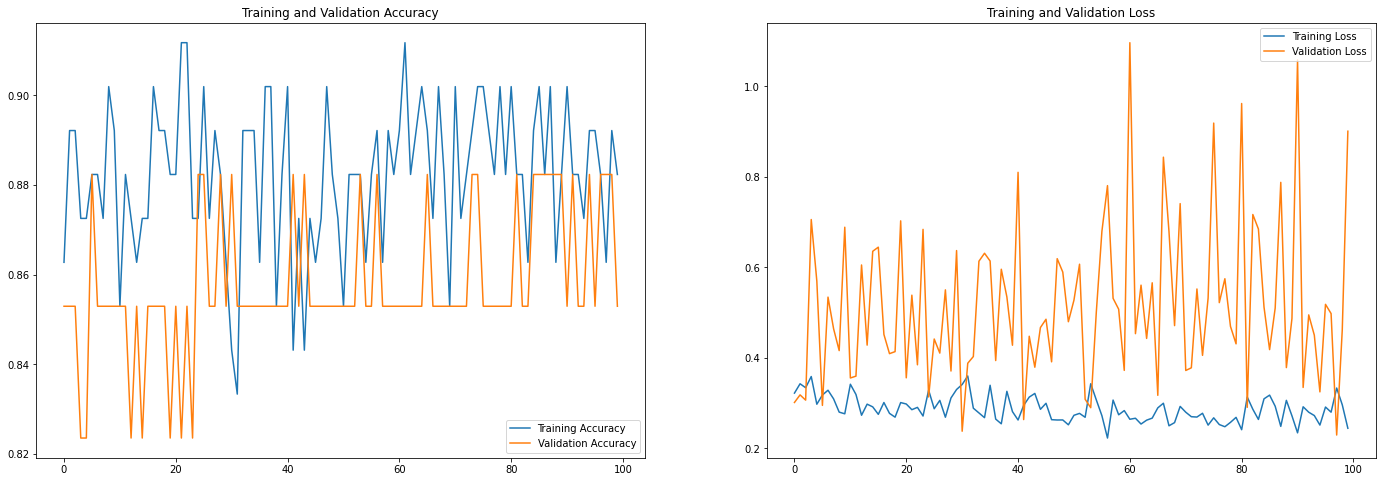

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()